In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# Load dataset (YOUR file only)
data = pd.read_csv("/content/sample_data/Heart_disease_cleveland_new.csv")

# Convert to binary target
data["target"] = data["target"].apply(lambda x: 1 if x > 0 else 0)

X = data.drop("target", axis=1)
y = data["target"]

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

In [85]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

metrics_rows = []

for name, model in models.items():

    model.fit(X_train_s, y_train)

    preds = model.predict(X_test_s)

    precision = precision_score(y_test, preds)
    recall    = recall_score(y_test, preds)
    f1        = f1_score(y_test, preds)

    metrics_rows.append([name, precision, recall, f1])

df_metrics = pd.DataFrame(
    metrics_rows,
    columns=["Algorithm", "Precision", "Recall", "F1 Score"]
)

print("\nMODEL COMPARISON TABLE")
print(df_metrics)


MODEL COMPARISON TABLE
             Algorithm  Precision    Recall  F1 Score
0  Logistic Regression   0.812500  0.928571  0.866667
1        Random Forest   0.818182  0.964286  0.885246
2                  SVM   0.806452  0.892857  0.847458


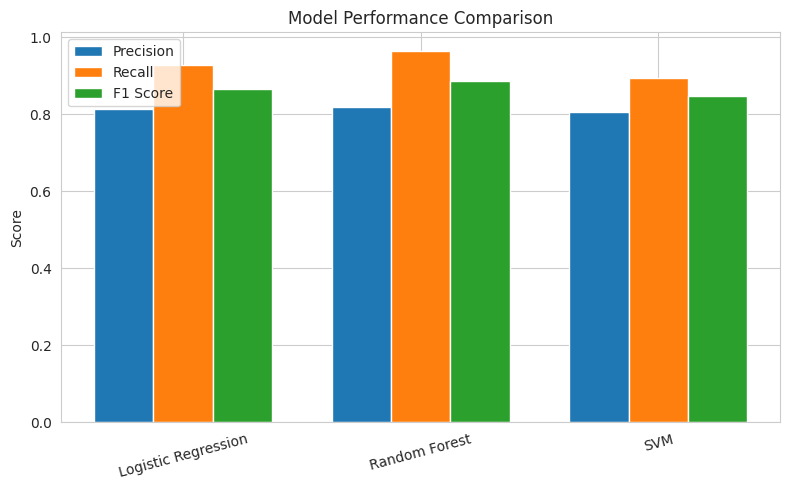

In [86]:
x = np.arange(len(df_metrics))
width = 0.25

plt.figure(figsize=(8,5))
plt.bar(x - width, df_metrics["Precision"], width, label="Precision")
plt.bar(x, df_metrics["Recall"], width, label="Recall")
plt.bar(x + width, df_metrics["F1 Score"], width, label="F1 Score")

plt.xticks(x, df_metrics["Algorithm"], rotation=15)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()

In [87]:
best_algo = df_metrics.sort_values(
    "F1 Score", ascending=False
).iloc[0]["Algorithm"]

best_model = models[best_algo]

print("\nBest Algorithm :", best_algo)


Best Algorithm : Random Forest


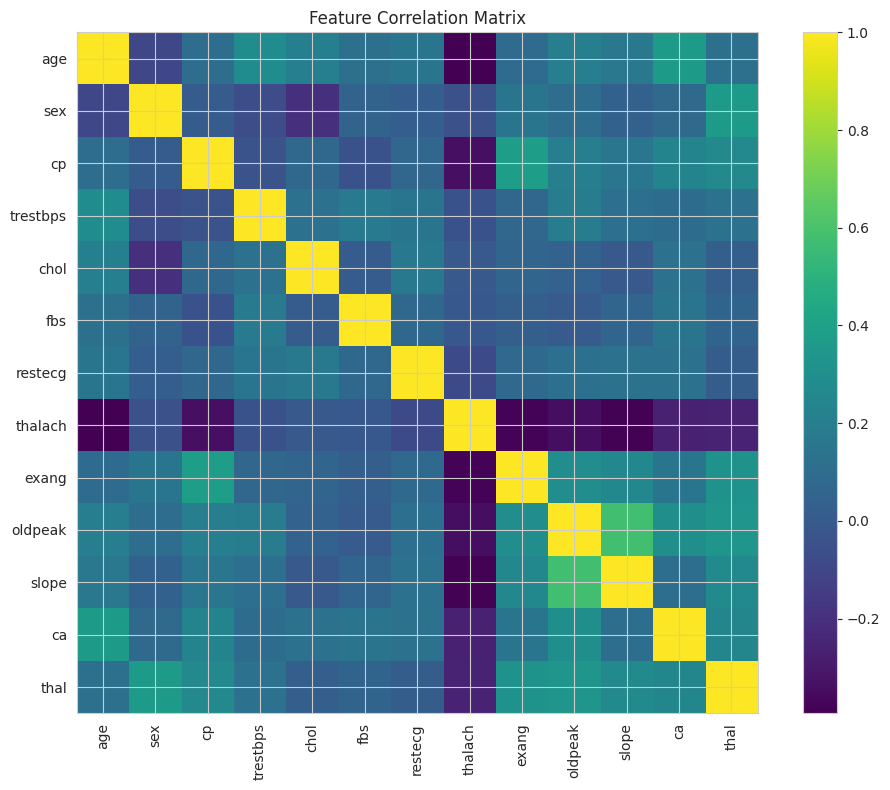

In [88]:
corr = X.corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, cmap="viridis")
plt.colorbar()
plt.title("Feature Correlation Matrix")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()

In [89]:
def risk_from_prob(p):
    if p < 0.40:
        return "Low Risk"
    elif p < 0.70:
        return "Medium Risk"
    else:
        return "High Risk"

In [90]:
all_scaled = scaler.transform(X)
all_probs = best_model.predict_proba(all_scaled)[:,1]

risk_df = pd.DataFrame({
    "Patient Index": X.index,
    "Heart Disease Probability": all_probs,
    "Risk Level": [risk_from_prob(p) for p in all_probs]
})

print("\nFULL PATIENT RISK TABLE")
print(risk_df.head())


FULL PATIENT RISK TABLE
   Patient Index  Heart Disease Probability   Risk Level
0              0                       0.16     Low Risk
1              1                       0.94    High Risk
2              2                       0.99    High Risk
3              3                       0.43  Medium Risk
4              4                       0.03     Low Risk


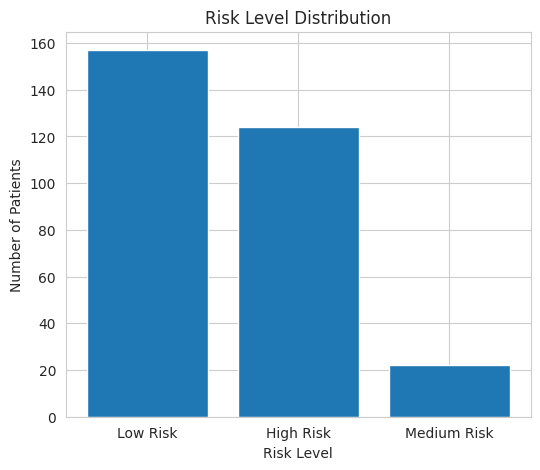

In [91]:
risk_counts = risk_df["Risk Level"].value_counts()

plt.figure(figsize=(6,5))
plt.bar(risk_counts.index, risk_counts.values)
plt.title("Risk Level Distribution")
plt.ylabel("Number of Patients")
plt.xlabel("Risk Level")
plt.show()

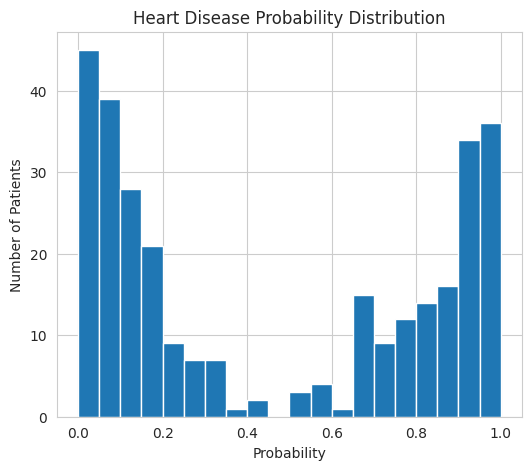

In [92]:
plt.figure(figsize=(6,5))
plt.hist(risk_df["Heart Disease Probability"], bins=20)
plt.title("Heart Disease Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Number of Patients")
plt.show()

In [93]:
low_row    = risk_df[risk_df["Risk Level"]=="Low Risk"].head(1)
medium_row = risk_df[risk_df["Risk Level"]=="Medium Risk"].head(1)
high_row   = risk_df[risk_df["Risk Level"]=="High Risk"].head(1)

last_3_history = pd.concat(
    [low_row, medium_row, high_row],
    ignore_index=True
)

print("\nLAST 3 HISTORY (Low, Medium, High guaranteed)")
print(last_3_history)


LAST 3 HISTORY (Low, Medium, High guaranteed)
   Patient Index  Heart Disease Probability   Risk Level
0              0                       0.16     Low Risk
1              3                       0.43  Medium Risk
2              1                       0.94    High Risk


In [94]:
last_3_history.to_csv("last_3_risk_history.csv", index=False)